In [1]:
import sys
import os
import numpy as np
import pandas as pd
import dill
import argparse
from tqdm import tqdm
from pyquaternion import Quaternion
from kalman_filter import NonlinearKinematicBicycle
from IPython.display import Image

nu_path = './devkit/python-sdk/'
sys.path.append(nu_path)
sys.path.append("../../trajectron")

from nuscenes.nuscenes import NuScenes
from nuscenes.map_expansion.map_api import NuScenesMap
from nuscenes.utils.splits import create_splits_scenes
from environment import Environment, Scene, Node, GeometricMap, derivative_of

"""From the script:

python process_data.py
    --data=./v1.0
    --version="v1.0-trainval"
    --output_path=../processed
"""

data_path = "./v1.0"
version = "v1.0-trainval"
val_split = 0.15

Uses code from
<https://github.com/nutonomy/nuscenes-devkit>

In [2]:
# loads the mainstream
nusc = NuScenes(
        version=version,
        dataroot=data_path,
        verbose=True)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 24.4 seconds.
Reverse indexing ...
Done reverse indexing in 6.7 seconds.


In [3]:
splits = create_splits_scenes()
for split_name, split_scenes in splits.items():
    print(f"scenes in {split_name}:", *split_scenes[:3], "...")

scenes in train: scene-0001 scene-0002 scene-0004 ...
scenes in val: scene-0003 scene-0012 scene-0013 ...
scenes in test: scene-0077 scene-0078 scene-0079 ...
scenes in mini_train: scene-0061 scene-0553 scene-0655 ...
scenes in mini_val: scene-0103 scene-0916 ...
scenes in train_detect: scene-0001 scene-0002 scene-0041 ...
scenes in train_track: scene-0004 scene-0005 scene-0006 ...


In [5]:
splits['val'][0]

'scene-0003'

In [25]:
# take scenes in (train, val) and convert these to (train, val, test) sets.
from sklearn.model_selection import train_test_split
train_scenes, val_scenes = train_test_split(
    splits['train' if 'mini' not in version else 'mini_train'], test_size=val_split)
train_scene_names = splits['train' if 'mini' not in version else 'mini_train']
val_scene_names = val_scenes
test_scene_names = splits['val' if 'mini' not in version else 'mini_val']

print("(train, val, test)")
print(train_scene_names[:5])
print(val_scene_names[:5])
print(test_scene_names[:5])
print("    with respective sizes",
        len(train_scene_names), len(val_scene_names), len(test_scene_names))

(train, val, test)
['scene-0001', 'scene-0002', 'scene-0004', 'scene-0005', 'scene-0006']
['scene-0598', 'scene-0050', 'scene-0989', 'scene-0254', 'scene-1075']
['scene-0003', 'scene-0012', 'scene-0013', 'scene-0014', 'scene-0015']
    with respective sizes 700 105 150


In [26]:
ns_scene_names = dict()
ns_scene_names['train'] = train_scene_names
ns_scene_names['val'] = val_scene_names
ns_scene_names['test'] = test_scene_names

In [27]:
# use this line to shrink the train set
# the original 
ns_scene_names['train'] = ns_scene_names['train'][:350]

`def field2token(self, table_name: str, field: str, query) -> List[str]`

This function queries all records for a certain field value, and returns the tokens for the matching records.
Warning: this runs in linear time.

In [6]:
help(NuScenes.field2token)

Help on function field2token in module nuscenes.nuscenes:

field2token(self, table_name:str, field:str, query) -> List[str]
    This function queries all records for a certain field value, and returns the tokens for the matching records.
    :param table_name: Table name.
    :param field: Field name. See README.md for details.
    :param query: Query to match against. Needs to type match the content of the query field.
    :return: List of tokens for the matching records.



## Getting a scene from the dataset

In [12]:
# getting metadata from scene in train set
ns_scene_name = ns_scene_names['train'][0]
ns_scene = nusc.get('scene', nusc.field2token('scene', 'name', ns_scene_name)[0])
print("looking at", ns_scene_name, "metadata")
ns_scene

looking at scene-0001 metadata


{'token': '73030fb67d3c46cfb5e590168088ae39',
 'log_token': '6b6513e6c8384cec88775cae30b78c0e',
 'nbr_samples': 40,
 'first_sample_token': 'e93e98b63d3b40209056d129dc53ceee',
 'last_sample_token': '40e413c922184255a94f08d3c10037e0',
 'name': 'scene-0001',
 'description': 'Construction, maneuver between several trucks'}

In [13]:
# getting metadata from scene in val set
ns_scene_name = ns_scene_names['val'][0]
ns_scene = nusc.get('scene', nusc.field2token('scene', 'name', ns_scene_name)[0])
print("looking at", ns_scene_name, "metadata")
ns_scene

looking at scene-0896 metadata


{'token': 'fd4ef697de684d0a8e016a8f8ae61193',
 'log_token': '65629cfc47fe489fabc497ead466a313',
 'nbr_samples': 40,
 'first_sample_token': 'c4bfd781001842f98f2677379c079e29',
 'last_sample_token': 'a1073293ce8544ce8f7c130c4e7fae4c',
 'name': 'scene-0896',
 'description': 'Rain, parked cars, peds, construction, fence, flooded road, construction vehicle, truck, parked motorcycles, narrow street, bus, parking lot'}

## Start processing the scene

First process scene by looping over each sample in the scene and:

1. extracting all the pedestrian and other vehicle annotations from the sample
2. extract ego vehicle pose and cam data

In [14]:
# every scene has a sample (snapshot of a scene in time?)
# extracting a sample from scene
ns_scene_name = ns_scene_names['train'][0]
ns_scene_token = nusc.field2token('scene', 'name', ns_scene_name)[0]
print("looking at scene", ns_scene_name, "with token", ns_scene_token)

ns_scene = nusc.get('scene', ns_scene_token)
sample_token = ns_scene['first_sample_token']
print("first_sample_token:", sample_token)
sample = nusc.get('sample', sample_token)
print("keys in sample:", *sample.keys())
print("timestamp:", sample['timestamp'])
print("next sample:", sample['next'])
print("prev sample:", sample['next'])
print("scene_token:", sample['scene_token'])
print("we have tokens for the following data:", *sample['data'].keys())
print(f"    that look like", sample['data']['RADAR_FRONT'])
annotation_tokens = sample['anns']
print("annotation tokens look like", annotation_tokens[0])
print(f"    there are {len(annotation_tokens)} of them")

looking at scene scene-0001 with token 73030fb67d3c46cfb5e590168088ae39
first_sample_token: e93e98b63d3b40209056d129dc53ceee
keys in sample: token timestamp prev next scene_token data anns
timestamp: 1531883530449377
next sample: 14d5adfe50bb4445bc3aa5fe607691a8
prev sample: 14d5adfe50bb4445bc3aa5fe607691a8
scene_token: 73030fb67d3c46cfb5e590168088ae39
we have tokens for the following data: RADAR_FRONT RADAR_FRONT_LEFT RADAR_FRONT_RIGHT RADAR_BACK_LEFT RADAR_BACK_RIGHT LIDAR_TOP CAM_FRONT CAM_FRONT_RIGHT CAM_BACK_RIGHT CAM_BACK CAM_BACK_LEFT CAM_FRONT_LEFT
    that look like bddd80ae33ec4e32b27fdb3c1160a30e
annotation tokens look like 173a50411564442ab195e132472fde71
    there are 10 of them


In [16]:
# extracting an annotation from sample
annotation_token = annotation_tokens[2]
annotation = nusc.get('sample_annotation', annotation_token)
print("looking at", annotation_token, "metadata")
annotation

looking at acce0b7220754600b700257a1de1573d metadata


{'token': 'acce0b7220754600b700257a1de1573d',
 'sample_token': 'e93e98b63d3b40209056d129dc53ceee',
 'instance_token': '39b6c31c9925492a8a9f1b0ef3b877b6',
 'visibility_token': '4',
 'attribute_tokens': ['58aa28b1c2a54dc88e169808c07331e3'],
 'translation': [1002.464, 632.267, 1.936],
 'size': [2.312, 7.516, 3.093],
 'rotation': [0.9343569321017062, 0.0, 0.0, -0.35633849558178193],
 'prev': '',
 'next': '4b1c1acb00c04dfe84e54f64a8381649',
 'num_lidar_pts': 171,
 'num_radar_pts': 7,
 'category_name': 'vehicle.truck'}

In [17]:
# extract attributes from annotation
nusc.get('attribute', annotation['attribute_tokens'][0])

{'token': '58aa28b1c2a54dc88e169808c07331e3',
 'name': 'vehicle.parked',
 'description': 'Vehicle is stationary (usually for longer duration) with no immediate intent to move.'}

In [18]:
# extract cam front data from sample
cam_front_token = sample['data']['CAM_FRONT']
print("looking at", cam_front_token, "metadata")
sample_data = nusc.get('sample_data', cam_front_token)
sample_data

looking at 020d7b4f858147558106c504f7f31bef metadata


{'token': '020d7b4f858147558106c504f7f31bef',
 'sample_token': 'e93e98b63d3b40209056d129dc53ceee',
 'ego_pose_token': '020d7b4f858147558106c504f7f31bef',
 'calibrated_sensor_token': '2e64b091b3b146a390c2606b9081343c',
 'timestamp': 1531883530412470,
 'fileformat': 'jpg',
 'is_key_frame': True,
 'height': 900,
 'width': 1600,
 'filename': 'samples/CAM_FRONT/n015-2018-07-18-11-07-57+0800__CAM_FRONT__1531883530412470.jpg',
 'prev': '',
 'next': 'caa2bfad0b8a4a8090cb0b803352cbc8',
 'sensor_modality': 'camera',
 'channel': 'CAM_FRONT'}

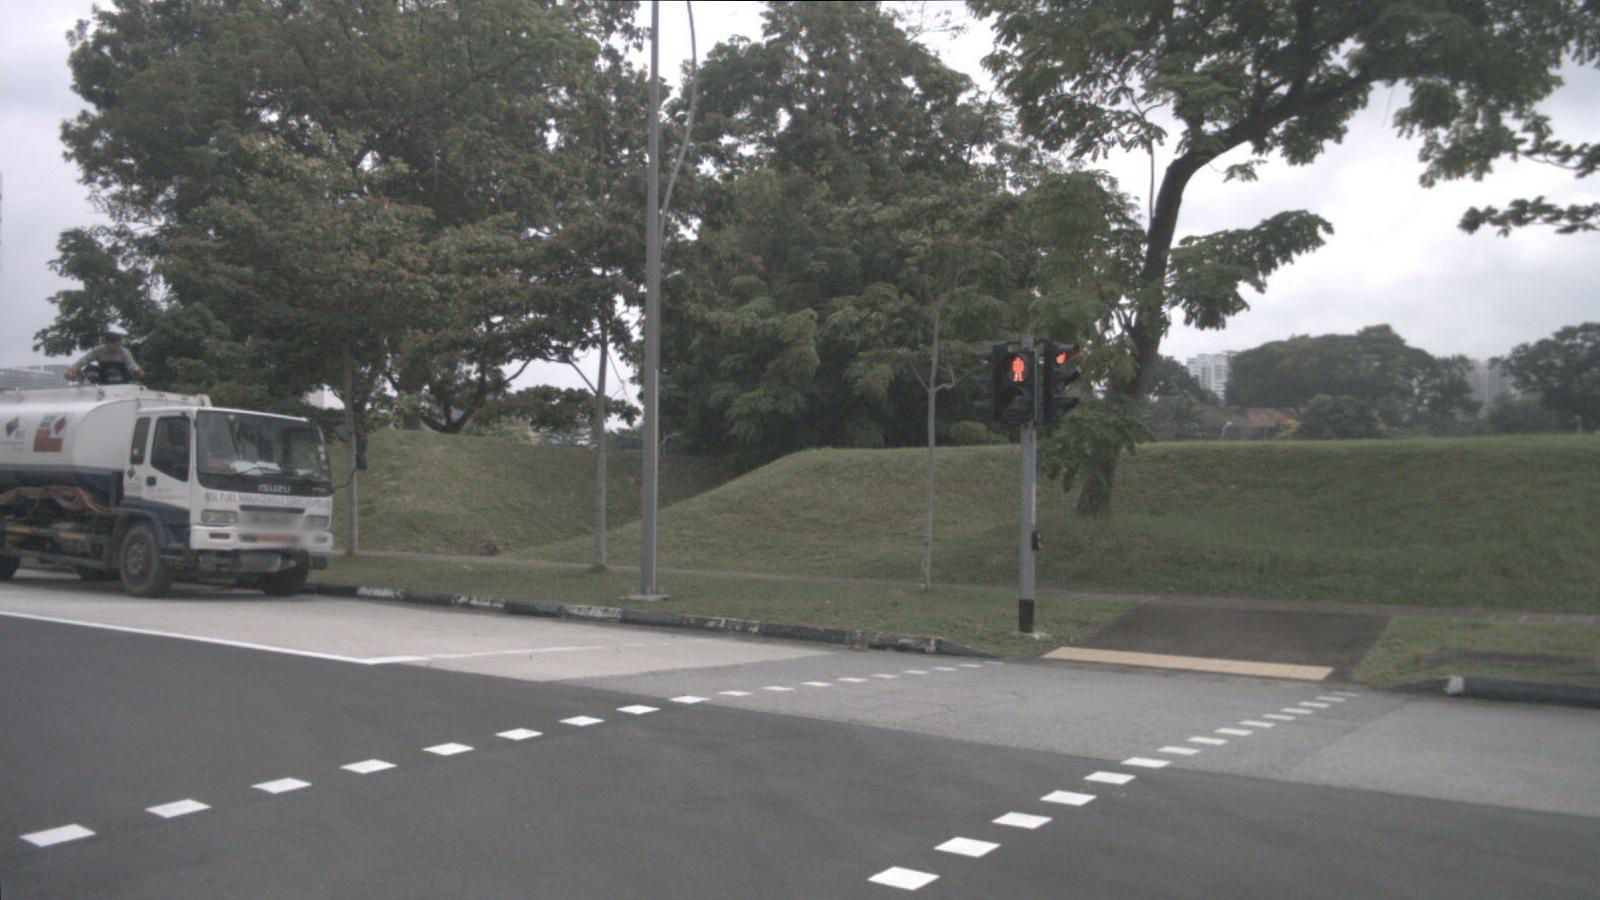

In [19]:
Image(os.path.join(data_path, sample_data['filename']))

In [20]:
# extract ego vehicle pose from cam front data (what is this?)
annotation = nusc.get('ego_pose', sample_data['ego_pose_token'])
annotation

{'token': '020d7b4f858147558106c504f7f31bef',
 'timestamp': 1531883530412470,
 'rotation': [-0.7530285141171715,
  -0.007718682910458633,
  0.00863090844122062,
  -0.6578859979358822],
 'translation': [1010.1102882349232, 610.6567106479714, 0.0]}

## Process more of the scene

In [21]:
help(NuScenesMap)

Help on class NuScenesMap in module nuscenes.map_expansion.map_api:

class NuScenesMap(builtins.object)
 |  NuScenesMap database class for querying and retrieving information from the semantic maps.
 |  Before using this class please use the provided tutorial in `map_demo.ipynb`.
 |  
 |  Below you can find the map origins (south eastern corner, in [lat, lon]) for each of the 4 maps in nuScenes:
 |  boston-seaport: [42.336849169438615, -71.05785369873047]
 |  singapore-onenorth: [1.2882100868743724, 103.78475189208984]
 |  singapore-hollandvillage: [1.2993652317780957, 103.78217697143555]
 |  singapore-queenstown: [1.2782562240223188, 103.76741409301758]
 |  
 |  The dimensions of the maps are as follows ([width, height] in meters):
 |  singapore-onenorth: [1585.6, 2025.0]
 |  singapore-hollandvillage: [2808.3, 2922.9]
 |  singapore-queenstown: [3228.6, 3687.1]
 |  boston-seaport: [2979.5, 2118.1]
 |  The rasterized semantic maps (e.g. singapore-onenorth.png) published with nuScenes v1

In [22]:
ns_scene_name = ns_scene_names['train'][0]
ns_scene_token = nusc.field2token('scene', 'name', ns_scene_name)[0]
print("looking at scene", ns_scene_name, "with token", ns_scene_token)
ns_scene = nusc.get('scene', ns_scene_token)

map_name = nusc.get('log', ns_scene['log_token'])['location']
print("the scene is in map", map_name)

nusc_map = NuScenesMap(dataroot=data_path, map_name=map_name)
# what is in nusc_map?

looking at scene scene-0001 with token 73030fb67d3c46cfb5e590168088ae39
the scene is in map singapore-onenorth


## Meat of the validation: extract partial dataset

All the metadata (annotations, bounding boxes, etc) is in v1.0-trainval_meta.tgz (0.43 GB).

The rest of the zip files are composed of camera and sweep data and comprises the most of the memory.

In [10]:
help(NuScenes.get)

Help on function get in module nuscenes.nuscenes:

get(self, table_name:str, token:str) -> dict
    Returns a record from table in constant runtime.
    :param table_name: Table name.
    :param token: Token of the record.
    :return: Table record. See README.md for record details for each table.



In [10]:
# check that I can use NuScenes.get() to retrieve scenes
for data_class in ['train', 'val', 'test']:
    scenes = []
    
    for ns_scene_name in tqdm(ns_scene_names[data_class]):
        ns_scene = nusc.get('scene', nusc.field2token('scene', 'name', ns_scene_name)[0])
        assert(isinstance(ns_scene, dict))
        # scene = process_scene(ns_scene, env, nusc, data_path)

100%|██████████| 150/150 [00:00<00:00, 28412.84it/s]


In [28]:
no_CAM_FRONT_data = 0

def process_scene(ns_scene, nusc, data_path):
    global no_CAM_FRONT_data
    sample_token = ns_scene['first_sample_token']
    sample = nusc.get('sample', sample_token)
    assert(isinstance(sample, dict))
    frame_id = 0
    while sample['next']:
        annotation_tokens = sample['anns']
        for annotation_token in annotation_tokens:
            annotation = nusc.get('sample_annotation', annotation_token)
            assert(isinstance(annotation, dict))
            if len(annotation['attribute_tokens']):
                attribute = nusc.get('attribute', annotation['attribute_tokens'][0])
                assert(isinstance(attribute, dict))

        sample_data = nusc.get('sample_data', sample['data']['CAM_FRONT'])
        assert(isinstance(sample_data, dict))
        if not os.path.isfile(os.path.join(data_path, sample_data['filename'])):
            no_CAM_FRONT_data += 1
        annotation = nusc.get('ego_pose', sample_data['ego_pose_token'])
        assert(isinstance(annotation, dict))

        sample = nusc.get('sample', sample['next'])
        assert(isinstance(sample, dict))
        frame_id += 1

# check that I can use NuScenes.get() to retrieve scenes
for data_class in ['train', 'val', 'test']:
    scenes = []
    for ns_scene_name in tqdm(ns_scene_names[data_class]):
        ns_scene = nusc.get('scene', nusc.field2token('scene', 'name', ns_scene_name)[0])
        scene = process_scene(ns_scene, nusc, data_path)

print(f"There are {no_CAM_FRONT_data} samples with no CAM_FRONT data")

100%|██████████| 150/150 [00:00<00:00, 452.46it/s]

There are 8870 samples with no CAM_FRONT data


In [18]:
scene_blacklist = [499, 515, 517]

FREQUENCY = 2
dt = 1 / FREQUENCY
data_columns_vehicle = pd.MultiIndex.from_product([['position', 'velocity', 'acceleration', 'heading'], ['x', 'y']])
data_columns_vehicle = data_columns_vehicle.append(pd.MultiIndex.from_tuples([('heading', '°'), ('heading', 'd°')]))
data_columns_vehicle = data_columns_vehicle.append(pd.MultiIndex.from_product([['velocity', 'acceleration'], ['norm']]))

data_columns_pedestrian = pd.MultiIndex.from_product([['position', 'velocity', 'acceleration'], ['x', 'y']])

curv_0_2 = 0
curv_0_1 = 0
total = 0

standardization = {
    'PEDESTRIAN': {
        'position': {
            'x': {'mean': 0, 'std': 1},
            'y': {'mean': 0, 'std': 1}
        },
        'velocity': {
            'x': {'mean': 0, 'std': 2},
            'y': {'mean': 0, 'std': 2}
        },
        'acceleration': {
            'x': {'mean': 0, 'std': 1},
            'y': {'mean': 0, 'std': 1}
        }
    },
    'VEHICLE': {
        'position': {
            'x': {'mean': 0, 'std': 80},
            'y': {'mean': 0, 'std': 80}
        },
        'velocity': {
            'x': {'mean': 0, 'std': 15},
            'y': {'mean': 0, 'std': 15},
            'norm': {'mean': 0, 'std': 15}
        },
        'acceleration': {
            'x': {'mean': 0, 'std': 4},
            'y': {'mean': 0, 'std': 4},
            'norm': {'mean': 0, 'std': 4}
        },
        'heading': {
            'x': {'mean': 0, 'std': 1},
            'y': {'mean': 0, 'std': 1},
            '°': {'mean': 0, 'std': np.pi},
            'd°': {'mean': 0, 'std': 1}
        }
    }
}

def augment(scene):
    scene_aug = np.random.choice(scene.augmented)
    scene_aug.temporal_scene_graph = scene.temporal_scene_graph
    scene_aug.map = scene.map
    return scene_aug

def process_scene(ns_scene, env, nusc, data_path):
    scene_id = int(ns_scene['name'].replace('scene-', ''))
    data = pd.DataFrame(columns=['frame_id',
                                 'type',
                                 'node_id',
                                 'robot',
                                 'x', 'y', 'z',
                                 'length',
                                 'width',
                                 'height',
                                 'heading'])

    sample_token = ns_scene['first_sample_token']
    sample = nusc.get('sample', sample_token)
    frame_id = 0
    while sample['next']:
        annotation_tokens = sample['anns']
        for annotation_token in annotation_tokens:
            annotation = nusc.get('sample_annotation', annotation_token)
            category = annotation['category_name']
            if len(annotation['attribute_tokens']):
                attribute = nusc.get('attribute', annotation['attribute_tokens'][0])['name']
            else:
                continue

            if 'pedestrian' in category and not 'stroller' in category and not 'wheelchair' in category:
                our_category = env.NodeType.PEDESTRIAN
            elif 'vehicle' in category and 'bicycle' not in category and 'motorcycle' not in category and 'parked' not in attribute:
                our_category = env.NodeType.VEHICLE
            else:
                continue

            data_point = pd.Series({'frame_id': frame_id,
                                    'type': our_category,
                                    'node_id': annotation['instance_token'],
                                    'robot': False,
                                    'x': annotation['translation'][0],
                                    'y': annotation['translation'][1],
                                    'z': annotation['translation'][2],
                                    'length': annotation['size'][0],
                                    'width': annotation['size'][1],
                                    'height': annotation['size'][2],
                                    'heading': Quaternion(annotation['rotation']).yaw_pitch_roll[0]})
            data = data.append(data_point, ignore_index=True)

        # Ego Vehicle
        our_category = env.NodeType.VEHICLE
        sample_data = nusc.get('sample_data', sample['data']['CAM_FRONT'])
        annotation = nusc.get('ego_pose', sample_data['ego_pose_token'])
        data_point = pd.Series({'frame_id': frame_id,
                                'type': our_category,
                                'node_id': 'ego',
                                'robot': True,
                                'x': annotation['translation'][0],
                                'y': annotation['translation'][1],
                                'z': annotation['translation'][2],
                                'length': 4,
                                'width': 1.7,
                                'height': 1.5,
                                'heading': Quaternion(annotation['rotation']).yaw_pitch_roll[0],
                                'orientation': None})
        data = data.append(data_point, ignore_index=True)

        sample = nusc.get('sample', sample['next'])
        frame_id += 1

    if len(data.index) == 0:
        return None

    data.sort_values('frame_id', inplace=True)
    max_timesteps = data['frame_id'].max()

    x_min = np.round(data['x'].min() - 50)
    x_max = np.round(data['x'].max() + 50)
    y_min = np.round(data['y'].min() - 50)
    y_max = np.round(data['y'].max() + 50)

    data['x'] = data['x'] - x_min
    data['y'] = data['y'] - y_min

    scene = Scene(timesteps=max_timesteps + 1, dt=dt, name=str(scene_id), aug_func=augment)

    # Generate Maps
    map_name = nusc.get('log', ns_scene['log_token'])['location']
    nusc_map = NuScenesMap(dataroot=data_path, map_name=map_name)

    type_map = dict()
    x_size = x_max - x_min
    y_size = y_max - y_min
    patch_box = (x_min + 0.5 * (x_max - x_min), y_min + 0.5 * (y_max - y_min), y_size, x_size)
    patch_angle = 0  # Default orientation where North is up
    canvas_size = (np.round(3 * y_size).astype(int), np.round(3 * x_size).astype(int))
    homography = np.array([[3., 0., 0.], [0., 3., 0.], [0., 0., 3.]])
    layer_names = ['lane', 'road_segment', 'drivable_area', 'road_divider', 'lane_divider', 'stop_line',
                   'ped_crossing', 'stop_line', 'ped_crossing', 'walkway']
    map_mask = (nusc_map.get_map_mask(patch_box, patch_angle, layer_names, canvas_size) * 255.0).astype(
        np.uint8)
    map_mask = np.swapaxes(map_mask, 1, 2)  # x axis comes first
    # PEDESTRIANS
    map_mask_pedestrian = np.stack((map_mask[9], map_mask[8], np.max(map_mask[:3], axis=0)), axis=0)
    type_map['PEDESTRIAN'] = GeometricMap(data=map_mask_pedestrian, homography=homography, description=', '.join(layer_names))
    # VEHICLES
    map_mask_vehicle = np.stack((np.max(map_mask[:3], axis=0), map_mask[3], map_mask[4]), axis=0)
    type_map['VEHICLE'] = GeometricMap(data=map_mask_vehicle, homography=homography, description=', '.join(layer_names))

    map_mask_plot = np.stack(((np.max(map_mask[:3], axis=0) - (map_mask[3] + 0.5 * map_mask[4]).clip(
        max=255)).clip(min=0).astype(np.uint8), map_mask[8], map_mask[9]), axis=0)
    type_map['VISUALIZATION'] = GeometricMap(data=map_mask_plot, homography=homography, description=', '.join(layer_names))

    scene.map = type_map
    del map_mask
    del map_mask_pedestrian
    del map_mask_vehicle
    del map_mask_plot

    return scene


counts = {
    'empty': 0,
    'total': 0}

for data_class in ['train', 'val', 'test']:
    env = Environment(node_type_list=['VEHICLE', 'PEDESTRIAN'], standardization=standardization)
    attention_radius = dict()
    attention_radius[(env.NodeType.PEDESTRIAN, env.NodeType.PEDESTRIAN)] = 10.0
    attention_radius[(env.NodeType.PEDESTRIAN, env.NodeType.VEHICLE)] = 20.0
    attention_radius[(env.NodeType.VEHICLE, env.NodeType.PEDESTRIAN)] = 20.0
    attention_radius[(env.NodeType.VEHICLE, env.NodeType.VEHICLE)] = 30.0

    env.attention_radius = attention_radius
    env.robot_type = env.NodeType.VEHICLE
    scenes = []

    for ns_scene_name in tqdm(ns_scene_names[data_class]):
        ns_scene = nusc.get('scene', nusc.field2token('scene', 'name', ns_scene_name)[0])
        scene_id = int(ns_scene['name'].replace('scene-', ''))
        if scene_id in scene_blacklist:  # Some scenes have bad localization
            continue

        scene = process_scene(ns_scene, env, nusc, data_path)
        if scene is None:
            counts['empty'] += 1
        counts['total'] += 1

print(counts)

100%|██████████| 150/150 [05:54<00:00,  2.37s/it]

{'empty': 0, 'total': 951}
